In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.nn.functional as F



In [2]:
data = pd.read_csv('../data/SMSSpamCollection', sep='\t', header=None)
data['Text'] = data[1].str.replace('[^\w\s]','')
data.columns = ['label', 'Full Text', 'Text']
data['Lower Case Text'] = data['Text'].str.lower()

In [3]:
labels, counts = np.unique(data['label'], return_counts=True)
encoder = preprocessing.LabelEncoder()
encoder.fit(labels[np.argsort(-counts)])
data['y'] = encoder.transform(data['label'])

In [4]:
np.random.seed(42)
mask_train = np.random.random(data.shape[0]) < 0.8
data_train = data[mask_train]
data_test = data.iloc[~mask_train, :]

In [5]:
#up sample data train for word2vec vocabulary
countToIncrease_word = data_train[data_train['y'] == 0].shape[0] - data_train[data_train['y'] == 1].shape[0]
spamupsampled_word = data_train[data_train['y'] == 1].sample(n=countToIncrease_word, replace=True)
data_train_upsample_word2vec = pd.concat([spamupsampled_word, data_train])

In [6]:
count_vect_sing_word = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
count_vect_sing_word.fit(data_train_upsample_word2vec['Lower Case Text'])
tokenizer_word = count_vect_sing_word.build_tokenizer()

In [7]:
VOCAB_SIZE = len(count_vect_sing_word.vocabulary_)
EMBEDDING_SIZE = 300
word_to_ix = count_vect_sing_word.vocabulary_

In [8]:
class TwoGramLanguageModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(TwoGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
    
    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [9]:
CONTEXT_SIZE = 1
EMBEDDING_DIM = EMBEDDING_SIZE

In [10]:
word2vec_model = TwoGramLanguageModeler(VOCAB_SIZE, EMBEDDING_DIM, CONTEXT_SIZE)

In [11]:
MODEL_PATH = '../data/word_2vec_model'
word_embeddings = word2vec_model.embeddings
word2vec_model.load_state_dict(torch.load(MODEL_PATH))
word2vec_model.eval()

TwoGramLanguageModeler(
  (embeddings): Embedding(8111, 300)
  (linear1): Linear(in_features=300, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=8111, bias=True)
)

In [12]:
## Word Embeddings

a = ENGLISH_STOP_WORDS

full_data = data['Text'].tolist()

cv = CountVectorizer(binary = True, stop_words = a)

full_data_transformed = cv.fit_transform(full_data)
fd = pd.DataFrame(full_data_transformed.toarray(), columns = cv.get_feature_names())
fd.shape

(5572, 9279)

In [13]:
sums = pd.DataFrame(fd.sum(axis=1))
sums = sums.reset_index()
sums.sort_values(by=0, ascending=False).head(5)

,index,0
1085,1085,53
1863,1863,51
2370,2370,51
5104,5104,51
2434,2434,49


In [14]:
# count_vect_sing_word is a CountVectorizer
def _indicesForSentence(input_str, tokenizer = tokenizer_word, count_vect = count_vect_sing_word):
    input_str = list(filter(lambda x: x in count_vect.vocabulary_, tokenizer(input_str)))
    return torch.tensor([[word_to_ix[word]] for word in input_str], dtype=torch.long)

def sentenceToNumpyInstance(input_str, embedder):
    embeddings = embedder(_indicesForSentence(input_str))
    if embeddings.shape == torch.Size([0]):
        return np.zeros(EMBEDDING_SIZE)
    else:
        return torch.Tensor.numpy(embeddings.detach())
    
def word2vec_transform(data, embeddings, field = 'Lower Case Text'):
    return np.array(data[field].apply(sentenceToNumpyInstance, embedder=embeddings).values.tolist())



In [15]:
embs = word2vec_transform(data, word_embeddings)
vec1 = embs[1085][0][0]
vec2 = embs[1863][0][0]
vec3 = embs[2370][0][0]
vec4 = embs[5104][0][0]
vec5 = embs[2434][0][0]


In [16]:
#Max word embedding 
print(vec1.shape)
vec1

(300,)


array([-0.18981096,  1.4227369 , -0.9902384 ,  1.2292829 ,  0.98955137,
        0.923227  , -0.18684249,  0.3918733 ,  0.7780009 , -0.9048305 ,
       -2.1496806 , -0.13471963, -0.36963987,  0.582406  ,  0.18956366,
        0.4845125 , -0.47391316, -0.43434104, -0.93856424,  0.11929535,
       -1.4997768 , -1.2167685 ,  0.20231733, -0.36255556, -0.91724104,
        0.39457127, -0.860566  , -0.4210809 ,  2.0554852 , -0.16308868,
       -0.32135576,  0.3605507 , -0.26749006, -0.74755085, -0.47850364,
        0.2970824 ,  0.1993891 ,  0.29878286,  0.3082507 , -1.2246063 ,
       -1.6436683 ,  1.7239445 ,  2.2355354 ,  0.31730568, -0.4736394 ,
       -1.2710063 ,  1.2342807 ,  0.06797076,  0.41186175, -1.1168177 ,
       -0.16750985,  1.7197348 , -1.4376853 , -1.8525515 ,  0.12735182,
        0.9485533 , -1.480798  ,  0.03132405,  0.6196161 ,  0.22978495,
       -1.7416118 ,  1.5940908 , -1.8554853 ,  0.20038296,  1.9638414 ,
        0.61478215, -1.1431602 ,  0.8820961 ,  0.6057215 , -0.58

In [17]:
import umap
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
%matplotlib inline

reducer = umap.UMAP()

vec1 = vec1.reshape(-1,1)
vec2 = vec2.reshape(-1,1)
vec3 = vec3.reshape(-1,1)
vec4 = vec4.reshape(-1,1)
vec5 = vec5.reshape(-1,1)

embedding1 = reducer.fit_transform(vec1)
embedding2 = reducer.fit_transform(vec2)
embedding3 = reducer.fit_transform(vec3)
embedding4 = reducer.fit_transform(vec4)
embedding5 = reducer.fit_transform(vec5)


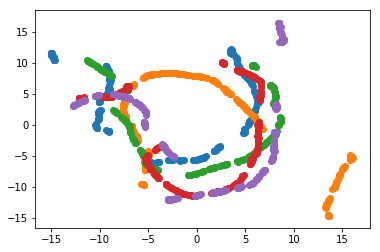

In [18]:
plt.scatter(embedding1[:,0], embedding1[:,1])
plt.scatter(embedding2[:,0], embedding2[:,1])
plt.scatter(embedding3[:,0], embedding3[:,1])
plt.scatter(embedding4[:,0], embedding4[:,1])
plt.scatter(embedding5[:,0], embedding5[:,1])
